In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# NN models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [86]:
# Get path to data directory
import os
workingdir = os.path.abspath(os.getcwd())
datadir = workingdir + '\data'

Get path to facial expression datasets

In [87]:
expressiondir = datadir + "\\facial_expressions"

In [88]:
expressiondir

'D:\\covidhackathon\\data\\facial_expressions'

In [89]:
datafile = expressiondir + '/data/legend.csv'
datafile2 = expressiondir + '/data/500_picts_satz.csv'
imagedir = expressiondir + '\\images'

# Start

In [105]:
file_labels = tf.data.experimental.CsvDataset(datafile, record_defaults=[tf.string, tf.string, tf.int32], header=True).shuffle(10000)

In [138]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL = 350, 350, 3
NUM_CLASSES = 3; 

def DecodeJPG(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def ProcessFiles(data_id, im_filename, emotion):
    full_filename = imagedir + '\\' + im_filename
    img = tf.io.read_file(full_filename)
    img = DecodeJPG(img)
    return img, emotion

In [139]:
img_labels = file_labels.map(ProcessFiles, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64).repeat()
img_labels_val = img_labels.take(2000)
img_labels_tra = img_labels.skip(2000)

In [140]:
iterator = img_labels.make_initializable_iterator()
next_op = iterator.get_next()

In [141]:
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.tables_initializer())
    img, lab = sess.run(next_op)
    print(lab)

[2 2 1 1 1 1 1 2 1 2 2 2 2 1 2 1 1 2 0 2 1 1 2 2 1 2 2 1 2 1 2 2 2 1 1 2 2
 2 0 1 2 1 1 1 1 1 1 1 2 1 1 2 0 1 1 1 2 2 2 2 1 1 2 2]


In [142]:
lab

array([2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1,
       2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2])

In [143]:
facevalue = {'negative': 0, 'happiness': 1, 'neutral': 2}

In [144]:
emotionweights = {0:1, 1:1.2, 2:5.3}

In [145]:
#We will create a simple architecture with 2 convolutional layers, one dense hidden layer and an output layer.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),strides = (2,2), padding = 'same', activation='relu',input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNEL)))
model.add(Conv2D(64, (3, 3), strides = (2,2), activation='relu'))
model.add(Conv2D(64, (3, 3), strides = (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

In [146]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [147]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 175, 175, 32)      896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 43, 43, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28224)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               3612800   
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 387       
Total para

In [148]:
history = model.fit(x=img_labels_tra, epochs=10, steps_per_epoch=100, verbose=1, validation_data=img_labels_val, validation_steps = 20)

Epoch 1/10
100/100 [==============================] - 342s 3s/step - loss: 0.8841 - acc: 0.5455 - val_loss: 0.7003 - val_acc: 0.7203
Epoch 2/10
100/100 [==============================] - 166s 2s/step - loss: 0.6551 - acc: 0.7301 - val_loss: 0.5518 - val_acc: 0.7734
Epoch 3/10
100/100 [==============================] - 161s 2s/step - loss: 0.6098 - acc: 0.7475 - val_loss: 0.5771 - val_acc: 0.8008
Epoch 4/10
100/100 [==============================] - 159s 2s/step - loss: 0.5622 - acc: 0.7813 - val_loss: 0.5331 - val_acc: 0.7969
Epoch 5/10
100/100 [==============================] - 161s 2s/step - loss: 0.5373 - acc: 0.7830 - val_loss: 0.4943 - val_acc: 0.8117
Epoch 6/10
100/100 [==============================] - 164s 2s/step - loss: 0.4983 - acc: 0.8039 - val_loss: 0.4890 - val_acc: 0.7953
Epoch 7/10
100/100 [==============================] - 165s 2s/step - loss: 0.4786 - acc: 0.8055 - val_loss: 0.5165 - val_acc: 0.8000
Epoch 8/10
100/100 [==============================] - 160s 2s/step - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


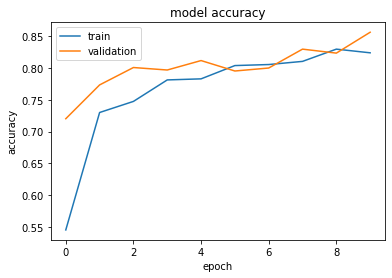

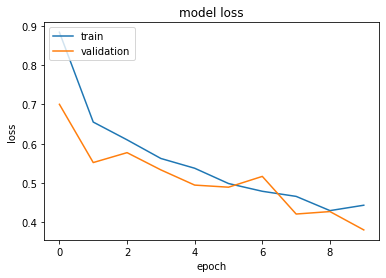

In [150]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [198]:
model.save('initialmodelthree')

In [152]:
prediction = model.predict(img_labels_val, steps = 1)

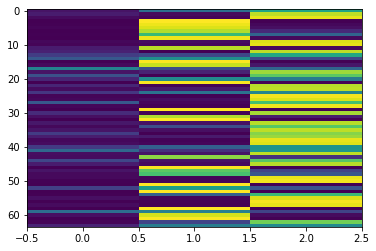

In [153]:
plt.imshow(prediction, aspect = 'auto')

In [177]:
iterator = img_labels_val.make_initializable_iterator()
next_op = iterator.get_next()
img_lst, lab_lst = [], []
with tf.Session() as sess:
    sess.run(iterator.initializer)
    sess.run(tf.tables_initializer())
    for _ in range(10):
        img, lab = sess.run(next_op)
        img_lst.append(img)
        lab_lst.append(lab)


In [178]:
acc_lst = []
for img, lab in zip(img_lst, lab_lst):
    pred = model.predict_classes(img)
    acc_lst.append(np.mean(np.equal(lab, pred)))
    


In [179]:
acc_lst

[0.921875,
 0.9375,
 0.921875,
 0.875,
 0.9375,
 0.84375,
 0.875,
 0.875,
 0.875,
 0.828125]

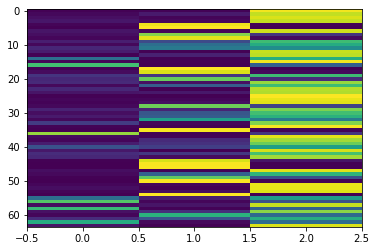

In [155]:
plt.imshow(pred, aspect = 'auto')

In [197]:
pred_label = np.argmax(prediction, axis = 1)
accuracy = np.mean(np.equal(lab, pred_label))
print('Accuracy =', accuracy)

Accuracy = 0.421875


In [190]:
np.sum(differ == 0)/len(pred_label)

0.578125

In [191]:
len(pred_label)

64

In [192]:
len(differ)

64

In [194]:
np.sum(differ)

27

In [195]:
differ

array([ True,  True, False,  True, False, False, False, False,  True,
        True,  True, False,  True,  True, False,  True, False, False,
        True, False, False, False, False, False, False, False,  True,
       False,  True, False, False,  True, False, False,  True, False,
       False, False,  True, False, False,  True, False, False,  True,
       False, False,  True, False,  True,  True, False,  True,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True])